In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    roc_auc_score,
)
from statsmodels.stats.contingency_tables import mcnemar

In [8]:
import seaborn as sns
data = pd.read_csv('../Data/diamonds.csv')
# Remove 0 values from x, y, z
data = data[data['x'] != 0]
data = data[data['y'] != 0]
data = data[data['z'] != 0]

numerical_features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Separate features (X) and target (y)
X = data.drop(columns=['price'], axis=1)  # Assuming 'price' is the target variable
y = data['price']

print("Shape of X:", X.shape)
print("Length of y:", len(y))

# Identify categorical columns
categorical_columns = ['cut', 'color', 'clarity']

# Apply OneHotEncoder to categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical_encoded = encoder.fit_transform(X[categorical_columns])

# Combine encoded categorical data with the rest of X
X_non_categorical = X.drop(columns=categorical_columns)
X_encoded = pd.concat(
    [X_non_categorical.reset_index(drop=True),
     pd.DataFrame(X_categorical_encoded, columns=encoder.get_feature_names_out(categorical_columns))],
    axis=1
)

# Standardize all features
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)

# Display the standardized data
X_std.head()



Shape of X: (53920, 9)
Length of y: 53920


,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.198204,-0.174203,-1.099725,-1.591573,-1.539219,-1.580084,-0.316234,1.225692,-0.585917,-0.537354,...,-0.426481,-0.334328,-0.234389,-0.185303,-0.565442,2.206908,-0.422586,-0.542311,-0.269617,-0.32202
1,-1.240417,-1.361090,1.585988,-1.645173,-1.662014,-1.750896,-0.316234,-0.815866,1.706727,-0.537354,...,-0.426481,-0.334328,-0.234389,-0.185303,1.768527,-0.453123,-0.422586,-0.542311,-0.269617,-0.32202
2,-1.198204,-3.385781,3.376463,-1.502241,-1.460280,-1.750896,3.162213,-0.815866,-0.585917,-0.537354,...,-0.426481,-0.334328,-0.234389,-0.185303,-0.565442,-0.453123,2.366380,-0.542311,-0.269617,-0.32202
3,-1.071566,0.454149,0.243131,-1.368242,-1.319943,-1.295396,-0.316234,-0.815866,1.706727,-0.537354,...,-0.426481,2.991071,-0.234389,-0.185303,-0.565442,-0.453123,-0.422586,1.843962,-0.269617,-0.32202
4,-1.029353,1.082501,0.243131,-1.243176,-1.214690,-1.124583,3.162213,-0.815866,-0.585917,-0.537354,...,-0.426481,-0.334328,4.266413,-0.185303,-0.565442,2.206908,-0.422586,-0.542311,-0.269617,-0.32202


In [10]:
# Function for training and evaluating models
def train_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """Train, evaluate, and return metrics for a given model."""
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    classification_rep = classification_report(y_test, y_pred_test, output_dict=True)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else None

    print(f"{model_name} Training Accuracy: {train_accuracy:.2f}")
    print(f"{model_name} Testing Accuracy: {test_accuracy:.2f}")
    print(f"\nClassification Report for {model_name} on Test Set:")
    print(classification_report(y_test, y_pred_test))

    return {
        "Model": model_name,
        "Test Accuracy": test_accuracy,
        "Precision (Survived)": classification_rep["1"]["precision"],
        "Recall (Survived)": classification_rep["1"]["recall"],
        "F1-Score (Survived)": classification_rep["1"]["f1-score"],
        "ROC-AUC": roc_auc,
    }

In [11]:
# Function for plotting confusion matrix and ROC curve
def plot_metrics(model, model_name, X_test, y_test):
    """Plot confusion matrix and ROC curve for a model."""
    y_pred_test = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    ConfusionMatrixDisplay(conf_matrix, display_labels=["Not Survived", "Survived"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    if hasattr(model, "predict_proba"):
        y_prob_test = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {model_name}")
        plt.legend(loc="lower right")
        plt.show()

In [12]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Convert to NumPy arrays
X_std_np = X_std.values
y_np = y.values

# Verify shapes
print("Shape of X_std_np:", X_std_np.shape)
print("Shape of y_np:", y_np.shape)



Shape of X_std_np: (53920, 23)
Shape of y_np: (53920,)


In [13]:
# Step 1: Define Price Ranges for Classification
bins = [0, 950, 5300, data['price'].max()]  # Define bin edges
labels = ['Low', 'Medium', 'High']  # Define labels for price ranges
data['price_category'] = pd.cut(data['price'], bins=bins, labels=labels)



In [14]:
from sklearn.model_selection import train_test_split

X = X_std  # standardized features
y = data['price_category']  # newly created price category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
# Find the most frequent class in the training set
most_frequent_class = y_train.mode()[0]
print(most_frequent_class)


Medium


In [16]:
# Predict the most frequent class for all instances in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)
print(y_pred_baseline[:5])

['Medium', 'Medium', 'Medium', 'Medium', 'Medium']


In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
baseline_model = LogisticRegression(max_iter=100)
baseline_model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, classification_report

# Predict and evaluate
y_pred = baseline_model.predict(X_test)
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline Model Accuracy: 0.9403746290801187
              precision    recall  f1-score   support

        High       0.95      0.95      0.95      2710
         Low       0.92      0.94      0.93      2698
      Medium       0.95      0.93      0.94      5376

    accuracy                           0.94     10784
   macro avg       0.94      0.94      0.94     10784
weighted avg       0.94      0.94      0.94     10784



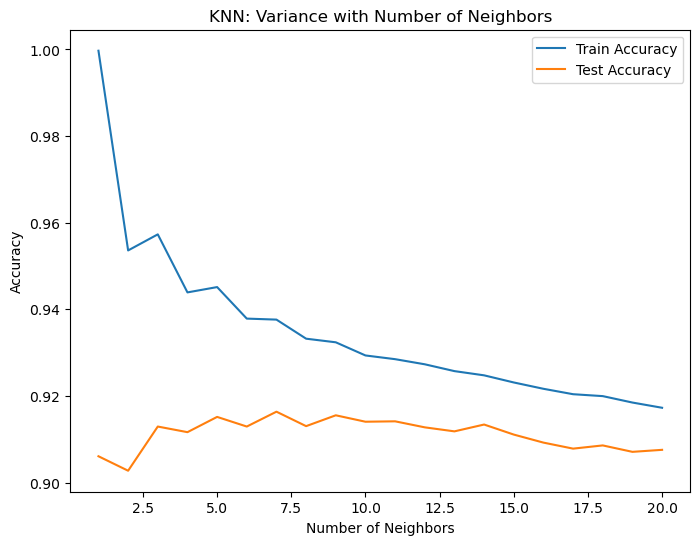

In [18]:
from sklearn.neighbors import KNeighborsClassifier
train_accuracy = {}
test_accuracy = {}
neighbors = range(1, 21)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracy[neighbor] = knn.score(X_train, y_train)
    test_accuracy[neighbor] = knn.score(X_test, y_test)

plt.figure(figsize=(8, 6))
plt.title("KNN: Variance with Number of Neighbors")
plt.plot(neighbors, list(train_accuracy.values()), label='Train Accuracy')
plt.plot(neighbors, list(test_accuracy.values()), label='Test Accuracy')
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()
    

In [19]:
# Encode price categories
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['price_category'])
print("Encoded price categories:", label_encoder.classes_)
print("Target distribution:\n", np.bincount(y))

# Step 2: Set Up Baseline Model for Classification
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_std, y)
baseline_predictions = baseline_model.predict(X_std)
baseline_accuracy = accuracy_score(y, baseline_predictions)
print("Baseline Model Accuracy:", baseline_accuracy)

# Step 3: Implement Two-Level Cross-Validation for Logistic Regression and KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier(n_neighbors=5)  # Start with 5, can be tuned

outer_scores = {'Logistic': [], 'KNN': []}

for train_idx, test_idx in outer_cv.split(X_std, y):
    X_train, X_test = X_std.values[train_idx], X_std.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    logistic_model.fit(X_train, y_train)
    knn_model.fit(X_train, y_train)
    
    logistic_pred = logistic_model.predict(X_test)
    knn_pred = knn_model.predict(X_test)
    
    outer_scores['Logistic'].append(accuracy_score(y_test, logistic_pred))
    outer_scores['KNN'].append(accuracy_score(y_test, knn_pred))

print("Logistic Regression Average Accuracy:", np.mean(outer_scores['Logistic']))
print("KNN Average Accuracy:", np.mean(outer_scores['KNN']))


Encoded price categories: ['High' 'Low' 'Medium']
Target distribution:
 [13552 13490 26878]
Baseline Model Accuracy: 0.4984792284866469
Logistic Regression Average Accuracy: 0.9401891691394659
KNN Average Accuracy: 0.915189169139466


In [97]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Assume X (features) and y (target) are defined as in previous steps
X = X_std.values

# Set up baseline model
baseline_model = DummyClassifier(strategy="most_frequent")

# Set up logistic regression with a range of regularization parameters
logistic_params = [0.001, 0.01, 0.1, 1, 10, 100]  # Range of C values to test
logistic_model = LogisticRegression(max_iter=1000)

# Choose k-Nearest Neighbors as method 2, with a range for k
#knn_params = [1, 3, 5, 7, 9]  # Range of k values
knn_params = [5,10,15,20,25]  # Range of k values
knn_model = KNeighborsClassifier()

# Outer cross-validation for model evaluation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

outer_scores = {'Baseline': [], 'Logistic': [], 'KNN': []}

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Baseline model
    baseline_model.fit(X_train, y_train)
    baseline_pred = baseline_model.predict(X_test)
    outer_scores['Baseline'].append(accuracy_score(y_test, baseline_pred))
    
    # Logistic Regression: Inner CV for hyperparameter tuning
    best_logistic_score = 0
    best_logistic_model = None
    for C in logistic_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_test = X[inner_train_idx], X[inner_test_idx]
            y_inner_train, y_inner_test = y[inner_train_idx], y[inner_test_idx]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_inner_train, y_inner_train)
            inner_scores.append(accuracy_score(y_inner_test, model.predict(X_inner_test)))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_logistic_score:
            best_logistic_score = avg_inner_score
            best_logistic_model = LogisticRegression(C=C, max_iter=1000)
    # Train best logistic model on outer train and evaluate on outer test
    best_logistic_model.fit(X_train, y_train)
    logistic_pred = best_logistic_model.predict(X_test)
    outer_scores['Logistic'].append(accuracy_score(y_test, logistic_pred))
    
    # k-Nearest Neighbors (kNN): Inner CV for hyperparameter tuning
    best_knn_score = 0
    best_knn_model = None
    for k in knn_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_test = X[inner_train_idx], X[inner_test_idx]
            y_inner_train, y_inner_test = y[inner_train_idx], y[inner_test_idx]
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(X_inner_train, y_inner_train)
            inner_scores.append(accuracy_score(y_inner_test, model.predict(X_inner_test)))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_knn_score:
            best_knn_score = avg_inner_score
            best_knn_model = KNeighborsClassifier(n_neighbors=k)
    # Train best kNN model on outer train and evaluate on outer test
    best_knn_model.fit(X_train, y_train)
    knn_pred = best_knn_model.predict(X_test)
    outer_scores['KNN'].append(accuracy_score(y_test, knn_pred))

# Display results
print("Baseline Average Accuracy:", np.mean(outer_scores['Baseline']))
print("Logistic Regression Average Accuracy:", np.mean(outer_scores['Logistic']))
print("KNN Average Accuracy:", np.mean(outer_scores['KNN']))


Baseline Average Accuracy: 0.4984792284866469
Logistic Regression Average Accuracy: 0.9422477744807122
KNN Average Accuracy: 0.915189169139466


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Assume X (features) and y (target) are defined as in previous steps
X = X_std.values

# Set up baseline model
baseline_model = DummyClassifier(strategy="most_frequent")

# Set up logistic regression with a range of regularization parameters
logistic_params = [0.001, 0.01, 0.1, 1, 10, 100]  # Range of C values to test
logistic_model = LogisticRegression(max_iter=1000)

# Choose k-Nearest Neighbors as method 2, with a range for k
knn_params = [5, 7, 9, 11, 13]  # Range of k values
knn_model = KNeighborsClassifier()

# Outer cross-validation for model evaluation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize table for results
results_table = {
    "Outer Fold": [],
    "Method 2 (k*)": [],
    "Method 2 E_test": [],
    "Logistic (λ*)": [],
    "Logistic E_test": [],
    "Baseline E_test": []
}

fold_number = 1

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Baseline model
    baseline_model.fit(X_train, y_train)
    baseline_pred = baseline_model.predict(X_test)
    baseline_error = 1 - accuracy_score(y_test, baseline_pred)
    
    # Logistic Regression: Inner CV for hyperparameter tuning
    best_logistic_score = 0
    best_logistic_model = None
    best_C = None
    for C in logistic_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_test = X[inner_train_idx], X[inner_test_idx]
            y_inner_train, y_inner_test = y[inner_train_idx], y[inner_test_idx]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_inner_train, y_inner_train)
            inner_scores.append(accuracy_score(y_inner_test, model.predict(X_inner_test)))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_logistic_score:
            best_logistic_score = avg_inner_score
            best_logistic_model = LogisticRegression(C=C, max_iter=1000)
            best_C = C
    # Train best logistic model on outer train and evaluate on outer test
    best_logistic_model.fit(X_train, y_train)
    logistic_pred = best_logistic_model.predict(X_test)
    logistic_error = 1 - accuracy_score(y_test, logistic_pred)
    
    # k-Nearest Neighbors (kNN): Inner CV for hyperparameter tuning
    best_knn_score = 0
    best_knn_model = None
    best_k = None
    for k in knn_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_test = X[inner_train_idx], X[inner_test_idx]
            y_inner_train, y_inner_test = y[inner_train_idx], y[inner_test_idx]
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(X_inner_train, y_inner_train)
            inner_scores.append(accuracy_score(y_inner_test, model.predict(X_inner_test)))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_knn_score:
            best_knn_score = avg_inner_score
            best_knn_model = KNeighborsClassifier(n_neighbors=k)
            best_k = k
    # Train best kNN model on outer train and evaluate on outer test
    best_knn_model.fit(X_train, y_train)
    knn_pred = best_knn_model.predict(X_test)
    knn_error = 1 - accuracy_score(y_test, knn_pred)

    # Append results for this fold
    results_table["Outer Fold"].append(fold_number)
    results_table["Method 2 (k*)"].append(best_k)
    results_table["Method 2 E_test"].append(knn_error)
    results_table["Logistic (λ*)"].append(best_C)
    results_table["Logistic E_test"].append(logistic_error)
    results_table["Baseline E_test"].append(baseline_error)

    fold_number += 1

# Display results as a DataFrame similar to Table 2
results_df = pd.DataFrame(results_table)
print(results_df)


/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyError: '[2207, 2314, 4791, 5471, 10167, 11182, 15951, 24520, 26123, 26243, 27112, 27429, 27503, 49556, 49557, 51506] not in index'

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Assume X (features) and y (target) are defined as in previous steps
X = X_std.values

# Set up baseline model
baseline_model = DummyClassifier(strategy="most_frequent")

# Set up logistic regression with a range of regularization parameters
logistic_params = [0.001, 0.01, 0.1, 1, 10, 100]  # Range of C values to test
logistic_model = LogisticRegression(max_iter=1000)

# Choose k-Nearest Neighbors as method 2, with a range for k
knn_params = [1, 3, 5, 7, 9]  # Range of k values
knn_model = KNeighborsClassifier()

# Outer cross-validation for model evaluation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize table for results
results_table = {
    "Outer Fold": [],
    "Method 2 (k*)": [],
    "Method 2 E_test": [],
    "Logistic (λ*)": [],
    "Logistic E_test": [],
    "Baseline E_test": []
}

# Initialize lists to collect true labels and predictions
all_true_labels = []
all_baseline_preds = []
all_logistic_preds = []
all_knn_preds = []

fold_number = 1

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Baseline model
    baseline_model.fit(X_train, y_train)
    baseline_pred = baseline_model.predict(X_test)
    baseline_error = 1 - accuracy_score(y_test, baseline_pred)
    
    # Logistic Regression: Inner CV for hyperparameter tuning
    best_logistic_score = 0
    best_logistic_model = None
    best_C = None
    for C in logistic_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_test = X[inner_train_idx], X[inner_test_idx]
            y_inner_train, y_inner_test = y[inner_train_idx], y[inner_test_idx]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_inner_train, y_inner_train)
            inner_scores.append(accuracy_score(y_inner_test, model.predict(X_inner_test)))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_logistic_score:
            best_logistic_score = avg_inner_score
            best_logistic_model = LogisticRegression(C=C, max_iter=1000)
            best_C = C
    # Train best logistic model on outer train and evaluate on outer test
    best_logistic_model.fit(X_train, y_train)
    logistic_pred = best_logistic_model.predict(X_test)
    logistic_error = 1 - accuracy_score(y_test, logistic_pred)
    
    # k-Nearest Neighbors (kNN): Inner CV for hyperparameter tuning
    best_knn_score = 0
    best_knn_model = None
    best_k = None
    for k in knn_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_test = X[inner_train_idx], X[inner_test_idx]
            y_inner_train, y_inner_test = y[inner_train_idx], y[inner_test_idx]
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(X_inner_train, y_inner_train)
            inner_scores.append(accuracy_score(y_inner_test, model.predict(X_inner_test)))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_knn_score:
            best_knn_score = avg_inner_score
            best_knn_model = KNeighborsClassifier(n_neighbors=k)
            best_k = k
    # Train best kNN model on outer train and evaluate on outer test
    best_knn_model.fit(X_train, y_train)
    knn_pred = best_knn_model.predict(X_test)
    knn_error = 1 - accuracy_score(y_test, knn_pred)

    # Collect true labels and predictions
    all_true_labels.extend(y_test)
    all_baseline_preds.extend(baseline_pred)
    all_logistic_preds.extend(logistic_pred)
    all_knn_preds.extend(knn_pred)
    
    # Append results for this fold
    results_table["Outer Fold"].append(fold_number)
    results_table["Method 2 (k*)"].append(best_k)
    results_table["Method 2 E_test"].append(knn_error)
    results_table["Logistic (λ*)"].append(best_C)
    results_table["Logistic E_test"].append(logistic_error)
    results_table["Baseline E_test"].append(baseline_error)

    fold_number += 1

# Display results as a DataFrame similar to Table 2
results_df = pd.DataFrame(results_table)
print(results_df)


   Outer Fold  Method 2 (k*)  Method 2 E_test  Logistic (λ*)  Logistic E_test  \
0           1              5         0.084662            100         0.054896   
1           2              5         0.086424            100         0.058976   
2           3              5         0.084106            100         0.059069   
3           4              5         0.087630            100         0.061665   
4           5              7         0.084106            100         0.054154   

   Baseline E_test  
0         0.501484  
1         0.501484  
2         0.501484  
3         0.501576  
4         0.501576  


In [53]:
from statsmodels.stats.contingency_tables import mcnemar

# Convert lists to numpy arrays for easier indexing
all_true_labels = np.array(all_true_labels)
all_baseline_preds = np.array(all_baseline_preds)
all_logistic_preds = np.array(all_logistic_preds)
all_knn_preds = np.array(all_knn_preds)


In [54]:
def perform_mcnemar_test(y_true, model1_pred, model2_pred, model1_name, model2_name):
    # Create contingency table
    both_correct = np.sum((model1_pred == y_true) & (model2_pred == y_true))
    model1_correct_model2_incorrect = np.sum((model1_pred == y_true) & (model2_pred != y_true))
    model1_incorrect_model2_correct = np.sum((model1_pred != y_true) & (model2_pred == y_true))
    both_incorrect = np.sum((model1_pred != y_true) & (model2_pred != y_true))
    
    table = [[both_correct, model1_correct_model2_incorrect],
             [model1_incorrect_model2_correct, both_incorrect]]
    
    print(f"\nContingency Table for {model1_name} vs {model2_name}:\n{pd.DataFrame(table, index=['Model1 Correct', 'Model1 Incorrect'], columns=['Model2 Correct', 'Model2 Incorrect'])}")
    
    # Perform McNemar's test
    result = mcnemar(table, exact=False, correction=True)
    print(f"McNemar's test statistic: {result.statistic}, p-value: {result.pvalue}")
    
    # Compute confidence interval for the difference in proportions
    b = model1_correct_model2_incorrect
    c = model1_incorrect_model2_correct
    n = b + c
    diff = (b - c) / n if n != 0 else 0
    se = np.sqrt((b + c - (b - c)**2 / n) / n) if n != 0 else 0
    z = 1.96  # For 95% confidence interval
    lower = diff - z * se
    upper = diff + z * se
    print(f"95% confidence interval for the difference in proportions: ({lower:.4f}, {upper:.4f})")
    
    return result.pvalue, (lower, upper)


In [55]:
# Logistic Regression vs Baseline
pvalue_logistic_baseline, ci_logistic_baseline = perform_mcnemar_test(
    all_true_labels, all_logistic_preds, all_baseline_preds, 'Logistic Regression', 'Baseline'
)

# kNN vs Baseline
pvalue_knn_baseline, ci_knn_baseline = perform_mcnemar_test(
    all_true_labels, all_knn_preds, all_baseline_preds, 'kNN', 'Baseline'
)

# Logistic Regression vs kNN
pvalue_logistic_knn, ci_logistic_knn = perform_mcnemar_test(
    all_true_labels, all_logistic_preds, all_knn_preds, 'Logistic Regression', 'kNN'
)



Contingency Table for Logistic Regression vs Baseline:
                  Model2 Correct  Model2 Incorrect
Model1 Correct             25242             25564
Model1 Incorrect            1636              1478
McNemar's test statistic: 21047.842977941178, p-value: 0.0
95% confidence interval for the difference in proportions: (-0.0523, 1.8117)

Contingency Table for kNN vs Baseline:
                  Model2 Correct  Model2 Incorrect
Model1 Correct             24572             24744
Model1 Incorrect            2306              2298
McNemar's test statistic: 18610.682772643253, p-value: 0.0
95% confidence interval for the difference in proportions: (-0.2652, 1.9242)

Contingency Table for Logistic Regression vs kNN:
                  Model2 Correct  Model2 Incorrect
Model1 Correct             48137              2669
Model1 Incorrect            1179              1935
McNemar's test statistic: 576.174896049896, p-value: 2.547554014106519e-127
95% confidence interval for the difference in 

In [56]:
import pandas as pd

# Calculate mean accuracy/error across folds for each model
results_df["Baseline Accuracy"] = 1 - results_df["Baseline E_test"]
results_df["Logistic Accuracy"] = 1 - results_df["Logistic E_test"]
results_df["kNN Accuracy"] = 1 - results_df["Method 2 E_test"]

mean_baseline_accuracy = results_df["Baseline Accuracy"].mean()
mean_logistic_accuracy = results_df["Logistic Accuracy"].mean()
mean_knn_accuracy = results_df["kNN Accuracy"].mean()

print("Mean Accuracies:")
print(f"Baseline: {mean_baseline_accuracy:.3f}")
print(f"Logistic Regression: {mean_logistic_accuracy:.3f}")
print(f"k-Nearest Neighbors: {mean_knn_accuracy:.3f}")


Mean Accuracies:
Baseline: 0.498
Logistic Regression: 0.942
k-Nearest Neighbors: 0.915


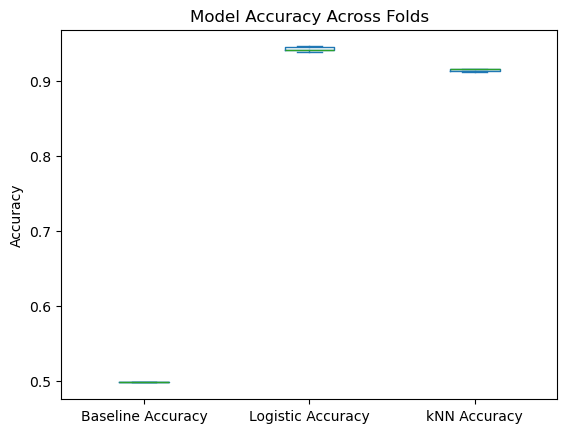

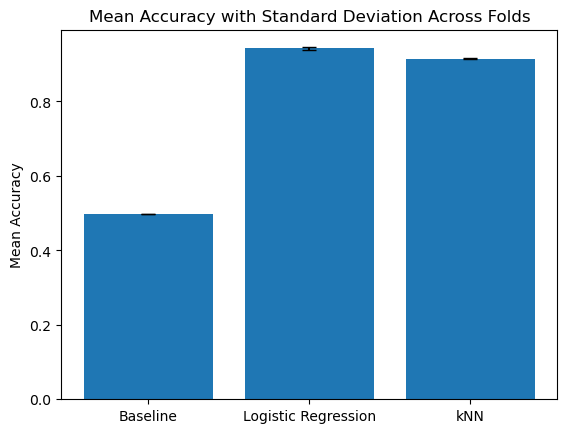

In [57]:
import matplotlib.pyplot as plt

# Boxplot for accuracy comparison
results_df[["Baseline Accuracy", "Logistic Accuracy", "kNN Accuracy"]].plot(kind="box", title="Model Accuracy Across Folds")
plt.ylabel("Accuracy")
plt.show()

# Alternatively, a bar plot with error bars for each model's mean accuracy
means = [mean_baseline_accuracy, mean_logistic_accuracy, mean_knn_accuracy]
stds = [results_df["Baseline Accuracy"].std(), results_df["Logistic Accuracy"].std(), results_df["kNN Accuracy"].std()]

plt.bar(["Baseline", "Logistic Regression", "kNN"], means, yerr=stds, capsize=5)
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy with Standard Deviation Across Folds")
plt.show()


In [58]:
import numpy as np

# Sample a subset of the true labels and predictions
np.random.seed(42)
sample_indices = np.random.choice(len(all_true_labels), size=500, replace=False)  # Adjust size as needed

# Subsample true labels and model predictions
sample_true_labels = all_true_labels[sample_indices]
sample_baseline_preds = all_baseline_preds[sample_indices]
sample_logistic_preds = all_logistic_preds[sample_indices]
sample_knn_preds = all_knn_preds[sample_indices]

# Re-run McNemar's test on the subsample
# Logistic Regression vs Baseline
perform_mcnemar_test(sample_true_labels, sample_logistic_preds, sample_baseline_preds, 'Logistic Regression', 'Baseline')

# kNN vs Baseline
perform_mcnemar_test(sample_true_labels, sample_knn_preds, sample_baseline_preds, 'kNN', 'Baseline')

# Logistic Regression vs kNN
perform_mcnemar_test(sample_true_labels, sample_logistic_preds, sample_knn_preds, 'Logistic Regression', 'kNN')



Contingency Table for Logistic Regression vs Baseline:
                  Model2 Correct  Model2 Incorrect
Model1 Correct               226               253
Model1 Incorrect              14                 7
McNemar's test statistic: 212.1498127340824, p-value: 4.664968331405157e-48
95% confidence interval for the difference in proportions: (0.0214, 1.7689)

Contingency Table for kNN vs Baseline:
                  Model2 Correct  Model2 Incorrect
Model1 Correct               228               247
Model1 Incorrect              12                13
McNemar's test statistic: 211.41312741312743, p-value: 6.754081007548819e-48
95% confidence interval for the difference in proportions: (0.0833, 1.7313)

Contingency Table for Logistic Regression vs kNN:
                  Model2 Correct  Model2 Incorrect
Model1 Correct               463                16
Model1 Incorrect              12                 9
McNemar's test statistic: 0.32142857142857145, p-value: 0.5707503880581739
95% confidence

(0.5707503880581739, (-1.7970397616199998, 2.0827540473342854))

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold

# Load data
data = pd.read_csv('../Data/diamonds_cleaned.csv')
# Preprocess data
X = data.drop(columns=['price'], axis=1)  # Assuming 'price' is the target variable
y = data['price']
categorical_columns = ['cut', 'color', 'clarity']

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical_encoded = encoder.fit_transform(X[categorical_columns])
X_non_categorical = X.drop(columns=categorical_columns)
X_encoded = pd.concat(
    [X_non_categorical.reset_index(drop=True),
     pd.DataFrame(X_categorical_encoded, columns=encoder.get_feature_names_out(categorical_columns))],
    axis=1
)

# Standardize features
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)

# Bin target variable
bins = [0, 950, 5300, data['price'].max()]
labels = ['Low', 'Medium', 'High']
data['price_category'] = pd.cut(data['price'], bins=bins, labels=labels)
X = X_std.values
y = data['price_category'].values

# Models and parameters
baseline_model = DummyClassifier(strategy="most_frequent")
logistic_params = [1000, 500, 100, 10, 1 ]
knn_params = [3, 5, 7, 9, 11]

# Set up cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Results table
results_table = {
    "Outer Fold": [],
    "Method 2 (k*)": [],
    "Method 2 E_test": [],
    "Logistic (λ*)": [],
    "Logistic E_test": [],
    "Baseline E_test": []
}

# Loop through outer folds
fold_number = 1
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Baseline model
    baseline_model.fit(X_train, y_train)
    baseline_pred = baseline_model.predict(X_test)
    baseline_error = 1 - accuracy_score(y_test, baseline_pred)
    
    # Logistic Regression with inner CV
    best_logistic_score, best_logistic_model, best_C = 0, None, None
    for C in logistic_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X[inner_train_idx], y[inner_train_idx])
            inner_scores.append(accuracy_score(y[inner_test_idx], model.predict(X[inner_test_idx])))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_logistic_score:
            best_logistic_score = avg_inner_score
            best_logistic_model = LogisticRegression(C=C, max_iter=1000)
            best_lambda = 1 / C
    
    # Train best logistic model on outer train and evaluate on outer test
    best_logistic_model.fit(X_train, y_train)
    logistic_pred = best_logistic_model.predict(X_test)
    logistic_error = 1 - accuracy_score(y_test, logistic_pred)
    
    # k-Nearest Neighbors (kNN) with inner CV
    best_knn_score, best_knn_model, best_k = 0, None, None
    for k in knn_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(X[inner_train_idx], y[inner_train_idx])
            inner_scores.append(accuracy_score(y[inner_test_idx], model.predict(X[inner_test_idx])))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_knn_score:
            best_knn_score = avg_inner_score
            best_knn_model = KNeighborsClassifier(n_neighbors=k)
            best_k = k
    
    # Train best kNN model on outer train and evaluate on outer test
    best_knn_model.fit(X_train, y_train)
    knn_pred = best_knn_model.predict(X_test)
    knn_error = 1 - accuracy_score(y_test, knn_pred)
    
    # Append results
    results_table["Outer Fold"].append(fold_number)
    results_table["Method 2 (k*)"].append(best_k)
    results_table["Method 2 E_test"].append(knn_error)
    results_table["Logistic (λ*)"].append(best_lambda)
    results_table["Logistic E_test"].append(logistic_error)
    results_table["Baseline E_test"].append(baseline_error)
    
    fold_number += 1

# Convert results to DataFrame
results_df = pd.DataFrame(results_table)
print(results_df)


   Outer Fold  Method 2 (k*)  Method 2 E_test  Logistic (λ*)  Logistic E_test  \
0           1              5         0.086678          0.001         0.057291   
1           2              5         0.086771          0.001         0.061741   
2           3              5         0.084925          0.002         0.059058   
3           4              5         0.086594          0.002         0.057575   
4           5              7         0.087614          0.002         0.058038   

   Baseline E_test  
0         0.501530  
1         0.501530  
2         0.501483  
3         0.501483  
4         0.501576  


Number of classes: 3
Number of features per class: 23

Feature Importance for Class 0 (Logistic Regression_CV):
          Feature  Coefficient  Abs_Coefficient
0           carat    15.688115        15.688115
3               x    14.354513        14.354513
4               y   -10.731064        10.731064
20    clarity_VS2     6.025831         6.025831
19    clarity_VS1     5.476447         5.476447
17    clarity_SI1     4.935790         4.935790
22   clarity_VVS2     4.887349         4.887349
21   clarity_VVS1     4.414033         4.414033
16     clarity_IF     3.480592         3.480592
18    clarity_SI2     3.109415         3.109415
15        color_J    -1.922452         1.922452
14        color_I    -1.921294         1.921294
13        color_H    -1.429831         1.429831
7       cut_Ideal     1.070381         1.070381
12        color_G    -0.988059         0.988059
5               z     0.949805         0.949805
8     cut_Premium     0.632612         0.632612
11        color_F    -0.

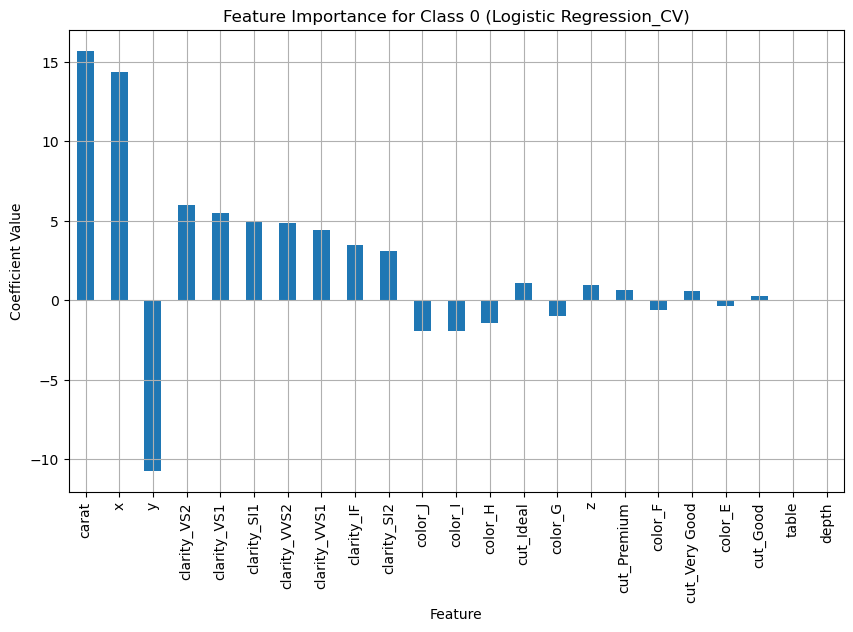


Feature Importance for Class 1 (Logistic Regression_CV):
          Feature  Coefficient  Abs_Coefficient
3               x   -26.862303        26.862303
4               y    26.263244        26.263244
0           carat   -23.478985        23.478985
20    clarity_VS2    -6.229757         6.229757
19    clarity_VS1    -5.705772         5.705772
17    clarity_SI1    -5.154480         5.154480
22   clarity_VVS2    -5.142038         5.142038
21   clarity_VVS1    -4.733578         4.733578
16     clarity_IF    -3.649797         3.649797
18    clarity_SI2    -3.554962         3.554962
14        color_I     1.859933         1.859933
15        color_J     1.705688         1.705688
5               z    -1.670496         1.670496
13        color_H     1.421304         1.421304
7       cut_Ideal    -1.059296         1.059296
12        color_G     0.994305         0.994305
8     cut_Premium    -0.749143         0.749143
11        color_F     0.644416         0.644416
9   cut_Very Good    -0.554087

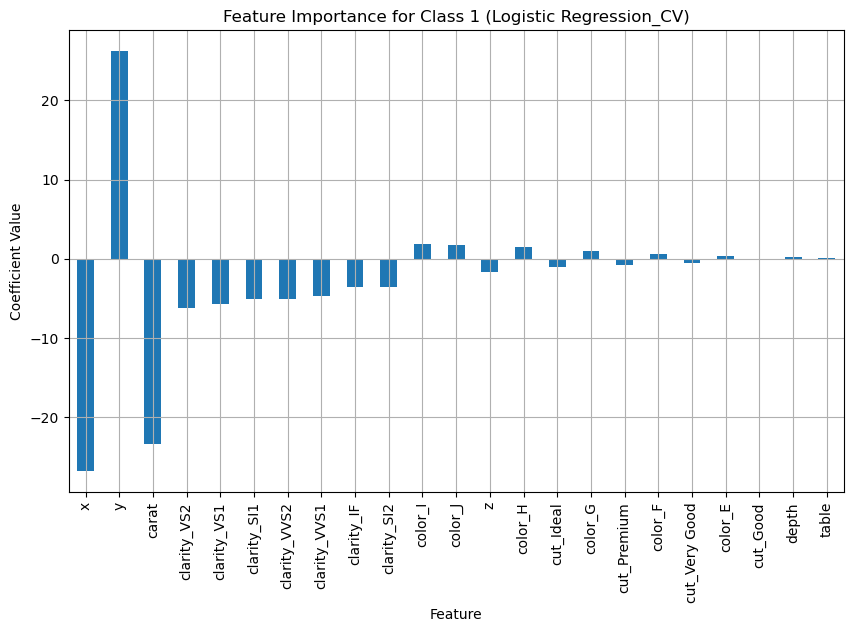


Feature Importance for Class 2 (Logistic Regression_CV):
          Feature  Coefficient  Abs_Coefficient
4               y   -15.532180        15.532180
3               x    12.507790        12.507790
0           carat     7.790870         7.790870
5               z     0.720691         0.720691
18    clarity_SI2     0.445547         0.445547
21   clarity_VVS1     0.319546         0.319546
22   clarity_VVS2     0.254689         0.254689
19    clarity_VS1     0.229325         0.229325
17    clarity_SI1     0.218690         0.218690
15        color_J     0.216764         0.216764
20    clarity_VS2     0.203926         0.203926
1           depth    -0.177910         0.177910
16     clarity_IF     0.169205         0.169205
8     cut_Premium     0.116531         0.116531
14        color_I     0.061361         0.061361
11        color_F    -0.038312         0.038312
2           table     0.038044         0.038044
6        cut_Good    -0.023064         0.023064
9   cut_Very Good    -0.011892

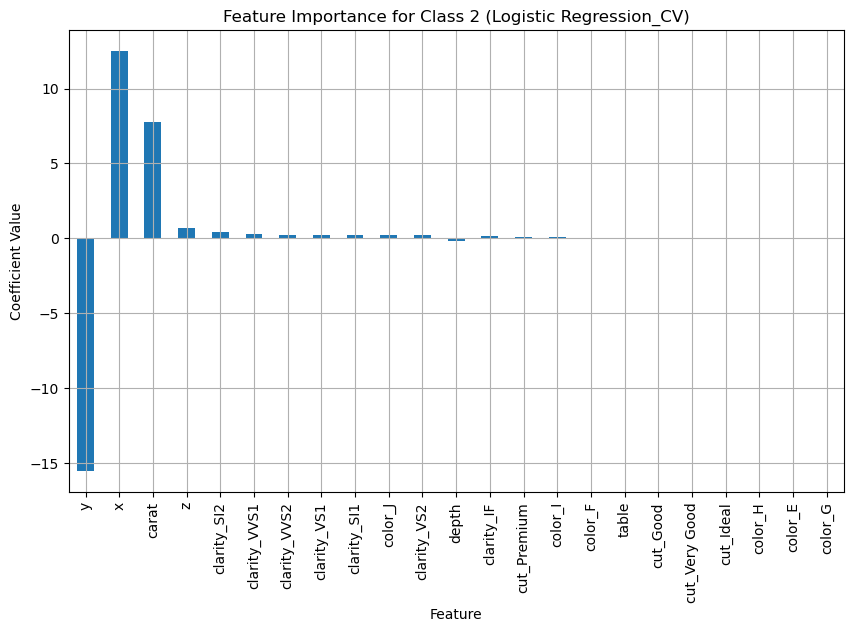

In [9]:
# Train Logistic Regression with the best lambda from cross-validation
logistic_regression_model_CV = LogisticRegression(C=1/best_lambda, random_state=42, max_iter=1000)
logistic_regression_model_CV.fit(X_train, y_train)  # Ensure X_train is scaled if needed

# Verify feature names and check number of classes
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_feature_names = encoder.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(categorical_feature_names)

# Check coefficient shape for multi-class handling
coefficients_matrix = logistic_regression_model_CV.coef_
num_classes, num_features = coefficients_matrix.shape
print("Number of classes:", num_classes)
print("Number of features per class:", num_features)

# Ensure the feature count matches the feature names length
if len(feature_names) == num_features:
    # Create a DataFrame to analyze feature importance for each class
    for class_index in range(num_classes):
        class_coefficients = coefficients_matrix[class_index]
        coefficients_df = pd.DataFrame({
            "Feature": feature_names,
            "Coefficient": class_coefficients,
            "Abs_Coefficient": np.abs(class_coefficients)  # Absolute value for ranking
        }).sort_values(by="Abs_Coefficient", ascending=False)

        # Display the coefficients for the current class
        print(f"\nFeature Importance for Class {class_index} (Logistic Regression_CV):")
        print(coefficients_df)

        # Plot feature importance for the current class
        coefficients_df.plot(kind="bar", x="Feature", y="Coefficient", legend=False, figsize=(10, 6))
        plt.title(f"Feature Importance for Class {class_index} (Logistic Regression_CV)")
        plt.ylabel("Coefficient Value")
        plt.xlabel("Feature")
        plt.grid()
        plt.show()
else:
    print("Mismatch between feature names and coefficients per class. Please verify the encoding steps.")


In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats import t

# Load data
data = pd.read_csv('../Data/diamonds_cleaned.csv')
# Preprocess data
X = data.drop(columns=['price'], axis=1)  # Assuming 'price' is the target variable
y = data['price']
categorical_columns = ['cut', 'color', 'clarity']

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical_encoded = encoder.fit_transform(X[categorical_columns])
X_non_categorical = X.drop(columns=categorical_columns)
X_encoded = pd.concat(
    [X_non_categorical.reset_index(drop=True),
     pd.DataFrame(X_categorical_encoded, columns=encoder.get_feature_names_out(categorical_columns))],
    axis=1
)

# Standardize features
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)

# Bin target variable
bins = [0, 950, 5300, data['price'].max()]
labels = ['Low', 'Medium', 'High']
data['price_category'] = pd.cut(data['price'], bins=bins, labels=labels)
X = X_std.values
y = data['price_category'].values

# Models and parameters
baseline_model = DummyClassifier(strategy="most_frequent")
logistic_params = [1000, 500, 100, 10, 0.1]
knn_params = [3, 5, 7, 9, 11]

# Set up cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store error differences for statistical analysis
error_diffs_log_knn = []
error_diffs_log_baseline = []
error_diffs_knn_baseline = []

# Loop through outer folds
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Baseline model
    baseline_model.fit(X_train, y_train)
    baseline_pred = baseline_model.predict(X_test)
    baseline_error = 1 - accuracy_score(y_test, baseline_pred)
    
    # Logistic Regression with inner CV
    best_logistic_score, best_logistic_model, best_C = 0, None, None
    for C in logistic_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X[inner_train_idx], y[inner_train_idx])
            inner_scores.append(accuracy_score(y[inner_test_idx], model.predict(X[inner_test_idx])))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_logistic_score:
            best_logistic_score = avg_inner_score
            best_logistic_model = LogisticRegression(C=C, max_iter=1000)
    
    # Train best logistic model on outer train and evaluate on outer test
    best_logistic_model.fit(X_train, y_train)
    logistic_pred = best_logistic_model.predict(X_test)
    logistic_error = 1 - accuracy_score(y_test, logistic_pred)
    
    # k-Nearest Neighbors (kNN) with inner CV
    best_knn_score, best_knn_model, best_k = 0, None, None
    for k in knn_params:
        inner_scores = []
        for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(X[inner_train_idx], y[inner_train_idx])
            inner_scores.append(accuracy_score(y[inner_test_idx], model.predict(X[inner_test_idx])))
        avg_inner_score = np.mean(inner_scores)
        if avg_inner_score > best_knn_score:
            best_knn_score = avg_inner_score
            best_knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # Train best kNN model on outer train and evaluate on outer test
    best_knn_model.fit(X_train, y_train)
    knn_pred = best_knn_model.predict(X_test)
    knn_error = 1 - accuracy_score(y_test, knn_pred)
    
    # Calculate error differences
    error_diffs_log_knn.append(logistic_error - knn_error)
    error_diffs_log_baseline.append(logistic_error - baseline_error)
    error_diffs_knn_baseline.append(knn_error - baseline_error)

# Convert lists to arrays
error_diffs_log_knn = np.array(error_diffs_log_knn)
error_diffs_log_baseline = np.array(error_diffs_log_baseline)
error_diffs_knn_baseline = np.array(error_diffs_knn_baseline)

# Calculate means and standard errors
mean_log_knn = np.mean(error_diffs_log_knn)
std_log_knn = np.std(error_diffs_log_knn, ddof=1) / np.sqrt(len(error_diffs_log_knn))

mean_log_baseline = np.mean(error_diffs_log_baseline)
std_log_baseline = np.std(error_diffs_log_baseline, ddof=1) / np.sqrt(len(error_diffs_log_baseline))

mean_knn_baseline = np.mean(error_diffs_knn_baseline)
std_knn_baseline = np.std(error_diffs_knn_baseline, ddof=1) / np.sqrt(len(error_diffs_knn_baseline))

# Calculate confidence intervals and p-values
alpha = 0.05
df = len(error_diffs_log_knn) - 1
t_crit = t.ppf(1 - alpha / 2, df)

ci_log_knn = (mean_log_knn - t_crit * std_log_knn, mean_log_knn + t_crit * std_log_knn)
ci_log_baseline = (mean_log_baseline - t_crit * std_log_baseline, mean_log_baseline + t_crit * std_log_baseline)
ci_knn_baseline = (mean_knn_baseline - t_crit * std_knn_baseline, mean_knn_baseline + t_crit * std_knn_baseline)

p_value_log_knn = 2 * t.cdf(-abs(mean_log_knn / std_log_knn), df)
p_value_log_baseline = 2 * t.cdf(-abs(mean_log_baseline / std_log_baseline), df)
p_value_knn_baseline = 2 * t.cdf(-abs(mean_knn_baseline / std_knn_baseline), df)

# Output results
print("Logistic vs kNN:")
print("Confidence Interval:", ci_log_knn)
print("P-value:", p_value_log_knn)

print("\nLogistic vs Baseline:")
print("Confidence Interval:", ci_log_baseline)
print("P-value:", p_value_log_baseline)

print("\nkNN vs Baseline:")
print("Confidence Interval:", ci_knn_baseline)
print("P-value:", p_value_knn_baseline)


Logistic vs kNN:
Confidence Interval: (-0.030450631328552552, -0.02510084586951073)
P-value: 8.615541222875139e-06

Logistic vs Baseline:
Confidence Interval: (-0.4450225356565022, -0.4405371147395809)
P-value: 6.645486578799506e-11

kNN vs Baseline:
Confidence Interval: (-0.41618167079320767, -0.4138265024048119)
P-value: 6.54561171944541e-12
